In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from collections import deque

In [25]:
# 1. Load dataset and pick a random video
dataset_path = "/kaggle/input/dcsass-dataset/DCSASS Dataset"
videos = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".mp4"):
            videos.append(os.path.join(root, file))

# Check if any videos are found
if not videos:
    print("No video files found in the dataset.")
else:
    # Pick a random video
    random_video = random.choice(videos)
    print(f"Selected video: {random_video}")

Selected video: /kaggle/input/dcsass-dataset/DCSASS Dataset/Robbery/Robbery115_x264.mp4/Robbery115_x264_19.mp4


In [26]:
# 2. Divide video into frames
frames = []
cap = cv2.VideoCapture(random_video)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Convert frame to grayscale for simplicity
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize frame to 84x84
    frames.append(cv2.resize(frame, (256, 256)))
cap.release()

# Convert frames list to numpy array
frames = np.array(frames)
print(f"Extracted {len(frames)} frames from the video.")

Extracted 30 frames from the video.


In [27]:
# 3. Define DDQN agent for anomaly detection
class DDQNAgent:
    def __init__(self, state_size, action_size, memory_limit=10000):
        self.memory = deque(maxlen=memory_limit)
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)  # Suppress progress logs
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            print(f"Skipping replay: memory size ({len(self.memory)}) < batch size ({batch_size})")
            return  # Skip replay if there are not enough experiences

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Episode 1/10
Skipping replay: memory size (29) < batch size (32)
Total reward in episode 1: -3


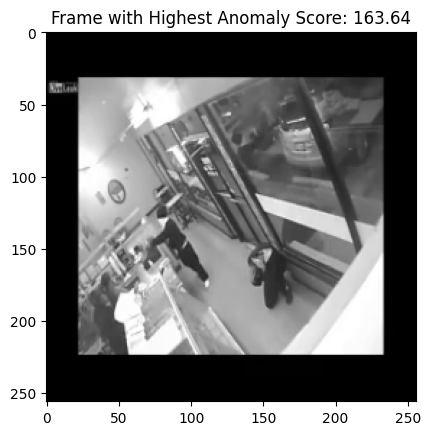

Episode 2/10
Total reward in episode 2: 3


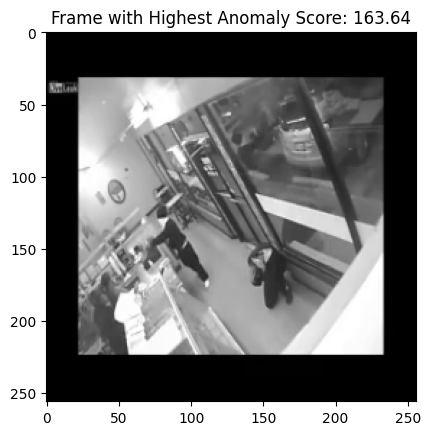

Episode 3/10
Total reward in episode 3: -1


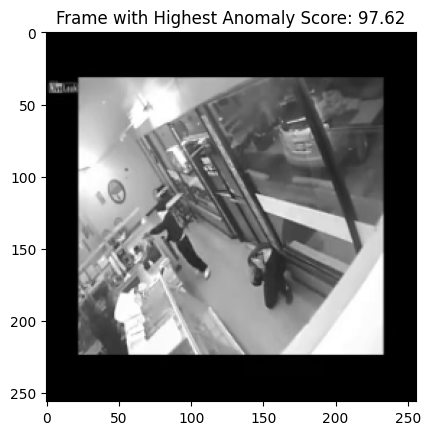

Episode 4/10
Total reward in episode 4: 7


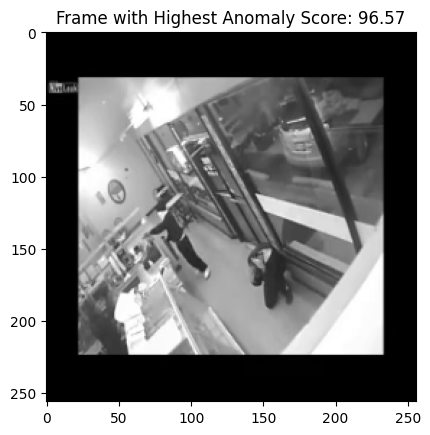

Episode 5/10
Total reward in episode 5: -3


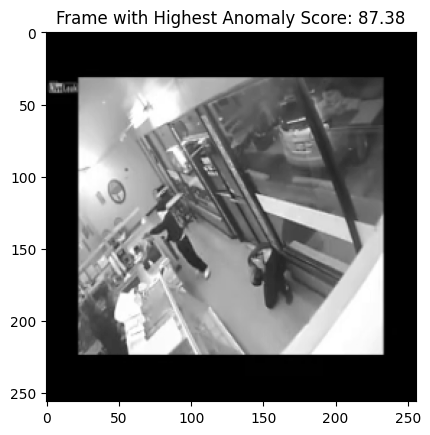

Episode 6/10
Total reward in episode 6: 7


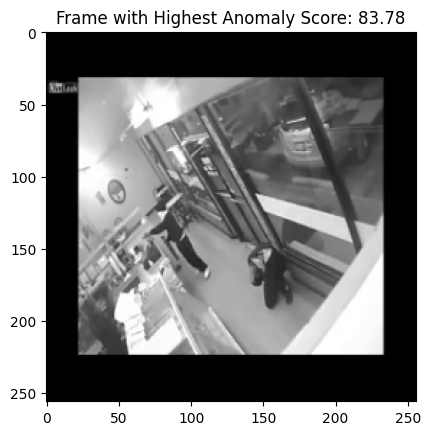

Episode 7/10
Total reward in episode 7: 13


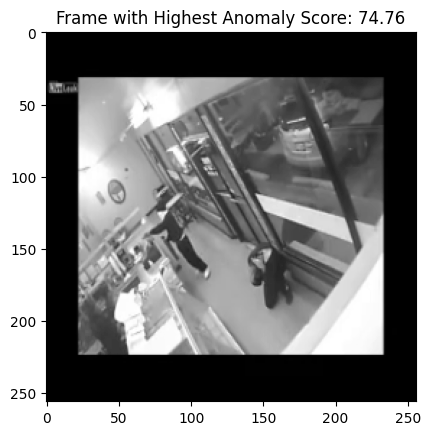

Episode 8/10
Total reward in episode 8: -11


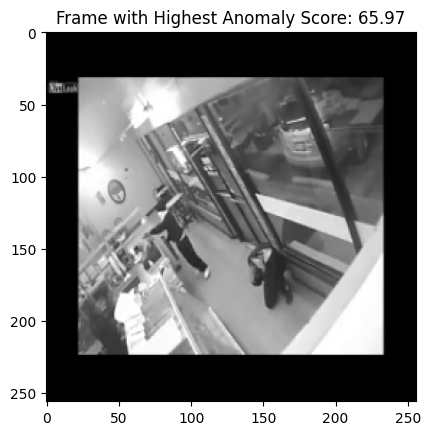

Episode 9/10
Total reward in episode 9: -1


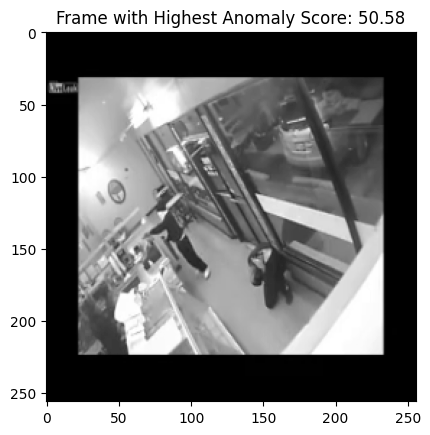

Episode 10/10
Total reward in episode 10: -3


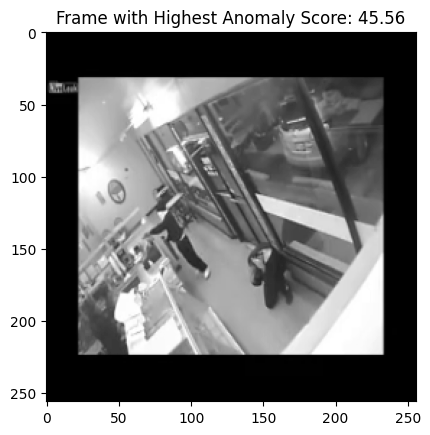

Total anomalies detected: 149


In [28]:
import matplotlib.pyplot as plt
import os

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 4. Train agent and detect anomalies
state_size = 256 * 256
action_size = 2  # Anomaly or normal
agent = DDQNAgent(state_size, action_size)
episodes = 10
anomalies = []

for e in range(episodes):
    print(f"Episode {e+1}/{episodes}")
    state = frames[0].flatten().reshape(1, -1)  # Initial frame
    total_reward = 0
    
    # Variables to track the highest anomaly score
    max_anomaly_score = -float('inf')  # Initialize to negative infinity
    frame_with_max_score = None  # To store the frame with the highest anomaly score
    
    for i in range(1, len(frames)):
        # The agent acts based on the state
        action = agent.act(state)
        
        # Calculate anomaly score (difference between Q-values)
        q_values = agent.model.predict(state, verbose=0)  # Suppress progress logs
        anomaly_score = q_values[0][1] - q_values[0][0]  # Anomaly score as the difference
        
        # Reward logic (1 for anomaly, -1 for normal)
        reward = 1 if action == 1 else -1
        total_reward += reward
        
        # Log anomalies if action == 1 (anomaly detected)
        if action == 1:
            anomalies.append((i, frames[i]))  # Log the anomaly (frame index and image)
        
        # Track the frame with the highest anomaly score
        if anomaly_score > max_anomaly_score:
            max_anomaly_score = anomaly_score
            frame_with_max_score = frames[i]  # Store the frame with the highest score
        
        # Move to the next state
        next_state = frames[i].flatten().reshape(1, -1)
        done = i == len(frames) - 1  # Check if it's the last frame
        
        # Store experience in the agent's memory
        agent.remember(state, action, reward, next_state, done)
        state = next_state
    
    # Perform experience replay after each episode
    agent.replay(32)  # Dynamic replay with memory safeguard
    
    # Print total reward for the episode
    print(f"Total reward in episode {e+1}: {total_reward}")
    
    # Update the target model after each episode
    agent.update_target_model()

    # After processing all frames, display the frame with the highest anomaly score
    if frame_with_max_score is not None:
        plt.imshow(frame_with_max_score, cmap="gray")
        plt.title(f"Frame with Highest Anomaly Score: {max_anomaly_score:.2f}")
        plt.show()

# After all episodes are completed, you can analyze the anomalies list
print(f"Total anomalies detected: {len(anomalies)}")